In [26]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA
from prophet import Prophet as prophet_model_lib
from sklearn.metrics import f1_score, recall_score, precision_score

import seaborn as sns
from statsmodels.tsa.stattools import adfuller


## Functions

In [2]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(18,6))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()
    # return ax

## Load & Preprocess Data

In [3]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
# df = df.asfreq(freq='T')
# df = df.interpolate()
df['label'] = df.label.astype(int)

In [4]:
df_hourly = df.resample('H').mean()

In [5]:
# Create a TimeSeries, specifying the time and value columns
# Set aside the last 20 percent of ts as a validation series

# series = TimeSeries.from_dataframe(df, value_cols='value')
# train, val = series[:-round(len(df) / 5)], series[-round(len(df) / 5):]

In [6]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
df['scaled'] = np_scaled
data = df['scaled'].to_frame()

In [7]:
train, val = train_test_split(df, train_size=0.7, shuffle=False)

exp_model = ExponentialSmoothing(seasonal_periods=seasonality_period)
exp_model.fit(train)
exp_prediction = exp_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
exp_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

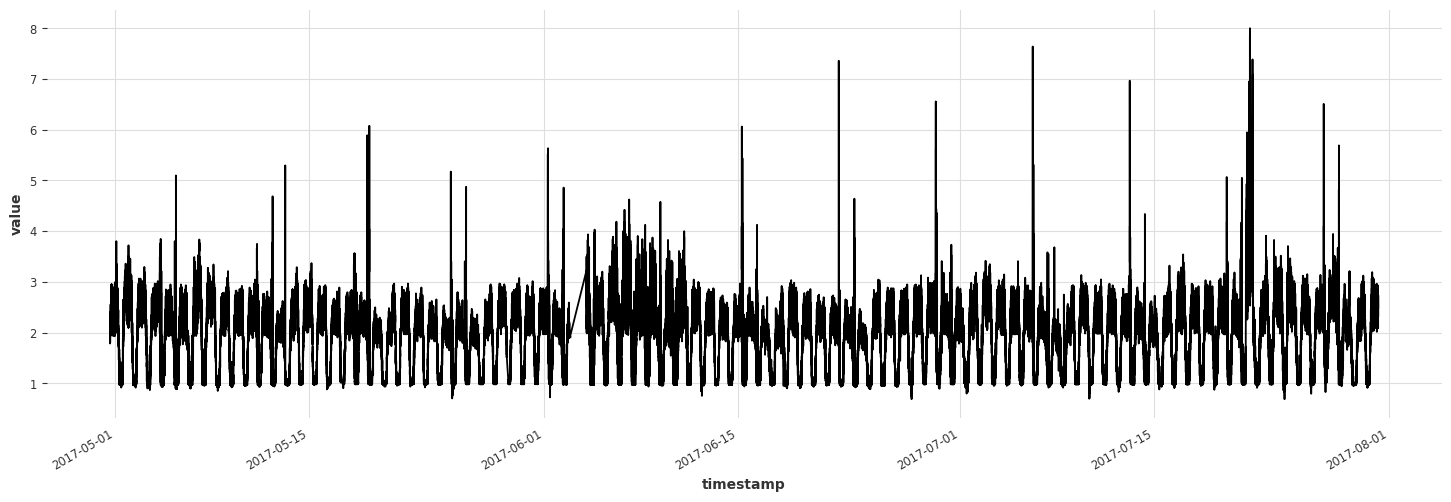

In [8]:
# Plot the time series
plt.rcParams["figure.figsize"] = (18,6)
df.value.plot()
plt.ylabel("value")
plt.show()

In [9]:
# Check occurence of seasonality and find the period of it
# is_sesonal, seasonality_period = check_seasonality(ts = series, m = None, max_lag = 100, alpha = 0.05)
# print("Seasonal:", is_sesonal, "Period:", seasonality_period)

In [10]:
# Checking being stationary or non stationary
# is_Stationary = stationarity_tests(ts = series, p_value_threshold_adfuller = 0.05, p_value_threshold_kpss = 0.05)
# if is_Stationary == False:
#     # Parameters can be changed to fit better
#     series = series.diff()
# else:
#     print("stationary already")

## Exponential Smoothing

In [35]:
# exp_model = ExponentialSmoothing(seasonal_periods=seasonality_period)
# exp_model.fit(train)
# exp_prediction = exp_model.predict(len(val), num_samples=1000)
# # Plotting the predictions
# series.plot()
# exp_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.legend()

In [34]:
# arima_model = ARIMA(9, 1, 5)
# arima_model.fit(train)
# arima_prediction = arima_model.predict(len(val), num_samples=1000)
# # Plotting the predictions
# series.plot()
# arima_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.legend()

In [33]:
# prophet_model = Prophet()
# prophet_model.fit(train)
# prophet_prediction = prophet_model.predict(len(val), num_samples=1000)
# # Plotting the predictions
# series.plot()
# prophet_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.legend()

## Prophet

17:17:11 - cmdstanpy - INFO - Chain [1] start processing
17:17:51 - cmdstanpy - INFO - Chain [1] done processing


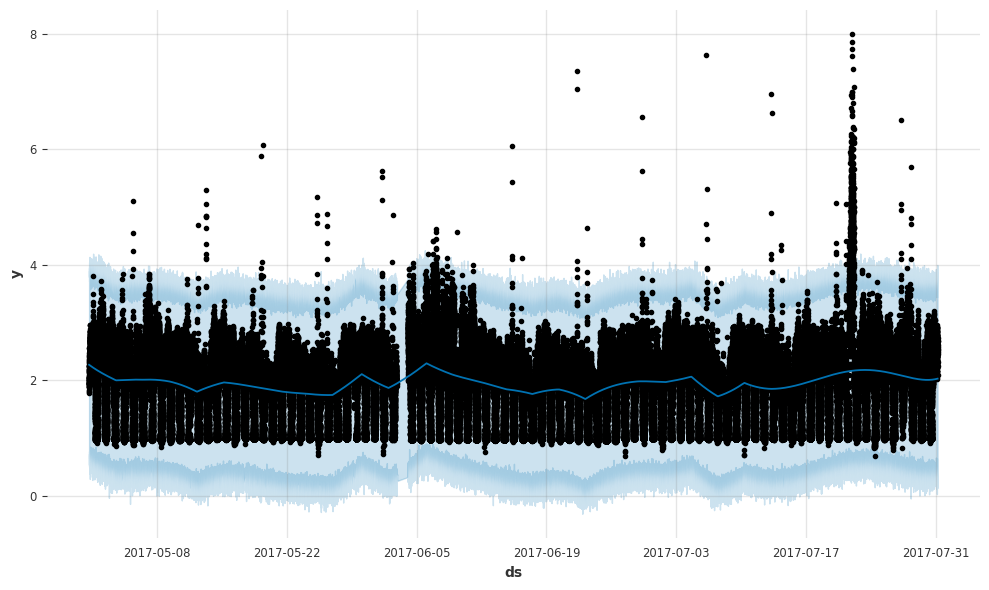

In [37]:
# train_df = TimeSeries.pd_dataframe(series).reset_index()
train_df = df['value'].reset_index()
train_df.columns = ["ds","y"]

# model preparation
prophet_model = prophet_model_lib(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
seasonality_mode = 'additive', interval_width = 0.99, changepoint_range = 0.8)
prophet_model = prophet_model.fit(train_df)

# forecast
forecast = prophet_model.predict(train_df)
prophet_model.plot(forecast)
plt.show()

In [38]:
# metrics of prediction
performance = pd.merge(train_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE {performance_MAE}')
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'MAPE {performance_MAPE}')

The MAE 0.5311519894672905
MAPE 0.34942807811076776


In [39]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# anomalies dataframe
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
653,2017-05-01 02:53:00,3.803279,2.218568,0.561359,3.719425,1
5060,2017-05-04 06:22:00,3.754098,2.005500,0.589183,3.750394,1
5138,2017-05-04 07:42:00,3.847458,2.005904,0.425742,3.563584,1
6537,2017-05-05 08:03:00,3.803279,2.011763,0.363002,3.737108,1
6654,2017-05-05 10:00:00,4.245902,2.012024,0.440755,3.761333,1
...,...,...,...,...,...,...
124467,2017-07-28 08:18:00,4.818182,2.043593,0.453673,3.658564,1
124468,2017-07-28 08:19:00,4.345455,2.043569,0.300383,3.758732,1
124469,2017-07-28 08:20:00,4.109091,2.043545,0.487358,3.781886,1
124470,2017-07-28 08:21:00,4.709091,2.043521,0.426701,3.932170,1


<AxesSubplot:xlabel='ds', ylabel='y'>

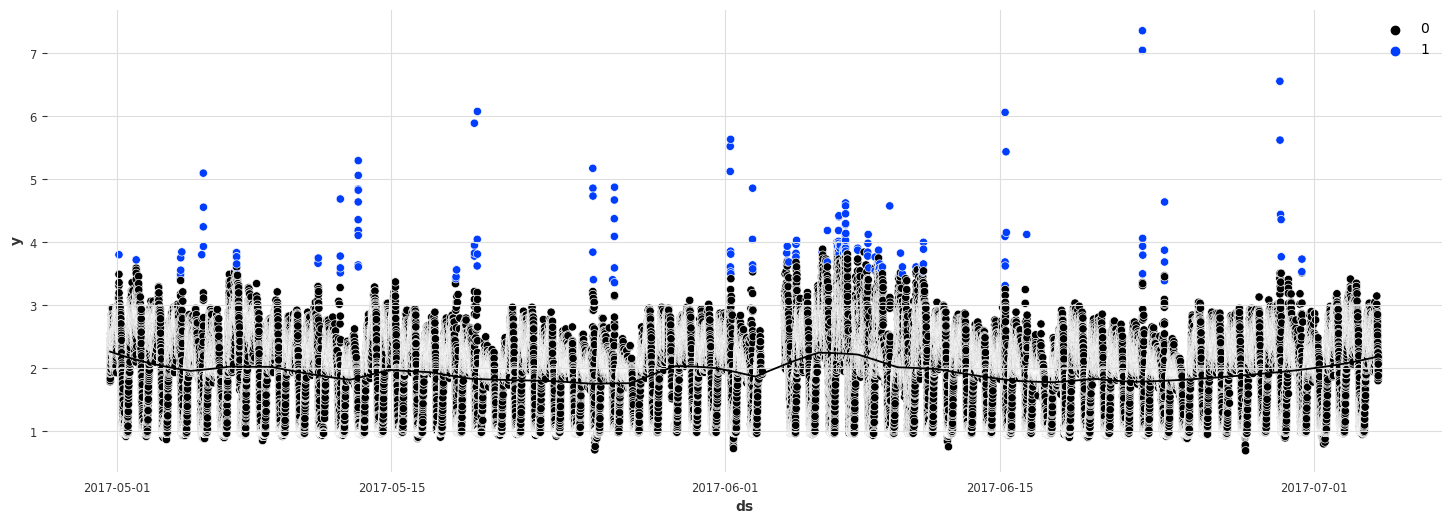

In [25]:
# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')

#### Metrics

In [29]:
performance

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
0,2017-04-30 16:00:00,1.901639,2.264890,0.656525,3.862366,0
1,2017-04-30 16:01:00,1.786885,2.264814,0.816254,3.890869,0
2,2017-04-30 16:02:00,2.000000,2.264737,0.691271,3.830831,0
3,2017-04-30 16:03:00,1.885246,2.264660,0.786065,3.724444,0
4,2017-04-30 16:04:00,1.819672,2.264583,0.665505,3.623299,0
...,...,...,...,...,...,...
89988,2017-07-04 06:22:00,1.950820,2.189460,0.581489,3.591721,0
89989,2017-07-04 06:23:00,1.916667,2.189517,0.595065,3.733406,0
89990,2017-07-04 06:24:00,1.967213,2.189574,0.631213,3.729023,0
89991,2017-07-04 06:25:00,2.065574,2.189630,0.432369,3.802900,0


In [31]:
f1_score(train['label'], performance['anomaly'])
# recall_score(df['label'], ae_prediction_df['cluster'])
# precision_score(df['label'], ae_prediction_df['cluster'])

0.038393253439857965

#### Root mean squared error 